In [1]:

import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline


In [2]:
from bs4 import BeautifulSoup

In [3]:
df = pd.read_csv('C:/Users/ACER/Downloads/movie/mpst_full_data.csv', delimiter=',')
nRow, nCol = df.shape
df.head(5)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [4]:
df['tags'].unique()

array(['cult, horror, gothic, murder, atmospheric', 'violence',
       'romantic', ..., 'violence, romantic, historical fiction',
       'suspenseful, neo noir, violence, tragedy, revenge, sentimental',
       'neo noir, realism, murder, violence, atmospheric, suspenseful'],
      dtype=object)

In [5]:
import re

def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
import string
def clean_text(text):
    text=re.sub(r'[^\w\s]','',text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = BeautifulSoup(text, 'lxml').get_text()
    text = decontracted(text)
    text = ' '.join(text.split()) 
    text = re.sub(r'\d+', '', text)
    text=" ".join(text.split())
    text = text.lower() 
    
    return text

In [7]:
df['clean_plot_synopsis'] = df['plot_synopsis'].apply(lambda x: clean_text(x))
print(df)
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)

df['tags']=df['tags'].apply(remove_spaces)
print(df['tags'])

         imdb_id                                          title  \
0      tt0057603                        I tre volti della paura   
1      tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
2      tt0033045                     The Shop Around the Corner   
3      tt0113862                             Mr. Holland's Opus   
4      tt0086250                                       Scarface   
...          ...                                            ...   
14823  tt0219952                                  Lucky Numbers   
14824  tt1371159                                     Iron Man 2   
14825  tt0063443                                     Play Dirty   
14826  tt0039464                                      High Wall   
14827  tt0235166                               Against All Hope   

                                           plot_synopsis  \
0      Note: this synopsis is for the orginal Italian...   
1      Two thousand years ago, Nhagruul the Foul, a s...   
2      Matusche

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_plot_synopsis'] = df['clean_plot_synopsis'].apply(lambda x: remove_stopwords(x))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
train=df.loc[df.split=='train']
train=train.reset_index()
test=df.loc[df.split=='test']
test=test.reset_index()
val=df.loc[df.split=="val"]
val=val.reset_index()
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train = vectorizer.fit_transform(train['tags']).toarray()
y_test = vectorizer.transform(test['tags']).toarray()
y_val = vectorizer.transform(val['tags']).toarray()

print(y_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
vectorizer.inverse_transform(y_train[0])

[array(['atmospheric', 'cult', 'gothic', 'horror', 'murder'], dtype='<U18')]

In [12]:
def max_len(x):
    a=x.split()
    return len(a)

max(df['plot_synopsis'].apply(max_len))

11406

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
vect=Tokenizer()
vect.fit_on_texts(train['plot_synopsis'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)

122195


In [16]:
xtrain1 = vect.texts_to_sequences(train['clean_plot_synopsis'])
max_length = vocab_size
xtrain = pad_sequences(xtrain1, maxlen=1200, padding='post')
print(xtrain)

[[  779  4660 62208 ...     0     0     0]
 [   51  4481   143 ...     0     0     0]
 [ 3793  8403   256 ...     0     0     0]
 ...
 [  140  2717   539 ...     0     0     0]
 [ 5118  2731  3015 ...     0     0     0]
 [ 1269  2392  2530 ...     0     0     0]]


In [17]:
vect.fit_on_texts(test['clean_plot_synopsis'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)
xtest1 = vect.texts_to_sequences(test['clean_plot_synopsis'])
max_length = vocab_size
xtest = pad_sequences(xtest1, maxlen=1200, padding='post')
print(xtest)
vect.fit_on_texts(val['clean_plot_synopsis'])
vocab_size = len(vect.word_index) + 1
print(vocab_size)
xval1 = vect.texts_to_sequences(val['clean_plot_synopsis'])
max_length = vocab_size
xval = pad_sequences(xval1, maxlen=1200, padding='post')
print(xval)

157464
[[131362   1637    551 ...      0      0      0]
 [  4870   2606    496 ...   1189   2133    295]
 [  6936   8446    181 ...      0      0      0]
 ...
 [  7140   3816    130 ...      0      0      0]
 [  1910  37006    747 ...      0      0      0]
 [  3739   1943     48 ...      0      0      0]]
182168
[[  5338   3627  17889 ...   6830     49    212]
 [   364  32781   3281 ...      0      0      0]
 [  3437     91    312 ...    669    600  10909]
 ...
 [    41     73   2372 ...      0      0      0]
 [182149    231   3663 ...      0      0      0]
 [  3366   2184    357 ...      0      0      0]]


In [15]:
model = keras.Sequential()
model.add(layers.Embedding(vocab_size, output_dim=50, input_length=1200))
model.add(layers.LSTM(128, return_sequences=True))  
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(71, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1200, 50)          6109750   
_________________________________________________________________
lstm (LSTM)                  (None, 1200, 128)         91648     
_________________________________________________________________
dropout (Dropout)            (None, 1200, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 71)                4615      
Total params: 6,255,421
Trainable params: 6,255,421
Non-trainable params: 0
______________________________________________

In [16]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = METRICS)

In [17]:
history = model.fit(xtrain,y_train,
                        epochs = 10,
                        verbose = 1,
                        validation_data=(xtest, y_test),
                        batch_size=16)

Epoch 1/10
594/594 [==============================] - 1549s 3s/step - loss: 0.2358 - tp: 887.9059 - fp: 7233.7462 - tn: 317169.8739 - fn: 13230.9849 - accuracy: 0.9186 - precision: 0.1046 - recall: 0.0844 - auc: 0.6890 - val_loss: 0.1428 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 201564.0000 - val_fn: 9022.0000 - val_accuracy: 0.9572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8300
Epoch 2/10
594/594 [==============================] - 1569s 3s/step - loss: 0.1478 - tp: 218.2639 - fp: 784.8185 - tn: 323763.3261 - fn: 13756.1025 - accuracy: 0.9575 - precision: 0.3033 - recall: 0.0174 - auc: 0.7943 - val_loss: 0.1416 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 201564.0000 - val_fn: 9022.0000 - val_accuracy: 0.9572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8302
Epoch 3/10
594/594 [==============================] - 1578s 3s/step - loss: 0.1434 - tp: 76.4739 - fp: 145.4504 - tn: 324397.9244 - fn: 13902.6622 - accuracy: 0.9588 - p

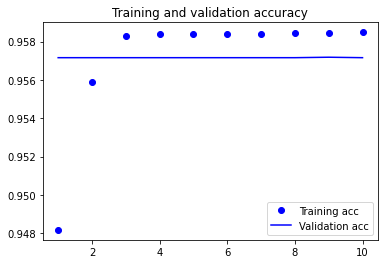

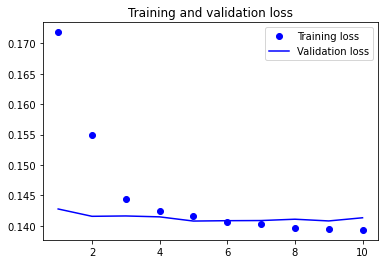

In [22]:
import matplotlib.pyplot as plt
ac = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(ac) + 1)
plt.plot(epochs, ac, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
def predict_sample():
    t = train.sample(1)
    encoded_docs = vect.texts_to_sequences(t['clean_plot_synopsis'])
    padded_docs = pad_sequences(encoded_docs, maxlen=1200, padding='post')
    pred = model.predict(padded_docs).tolist()
    for i in range(len(pred[0])):
        if(pred[0][i] < 0.1):
            pred[0][i] = 0
        else:
            pred[0][i] = 1
    
    print("Original tags -->", t['tags'].values)
    print("Predicted tags -->", vectorizer.inverse_transform(pred[0])[0])

predict_sample()

Original tags --> ['violence']
Predicted tags --> ['comedy' 'cult' 'flashback' 'murder' 'psychedelic' 'revenge' 'romantic'
 'violence']
